## BFGS + interpolação quadrática

In [1]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

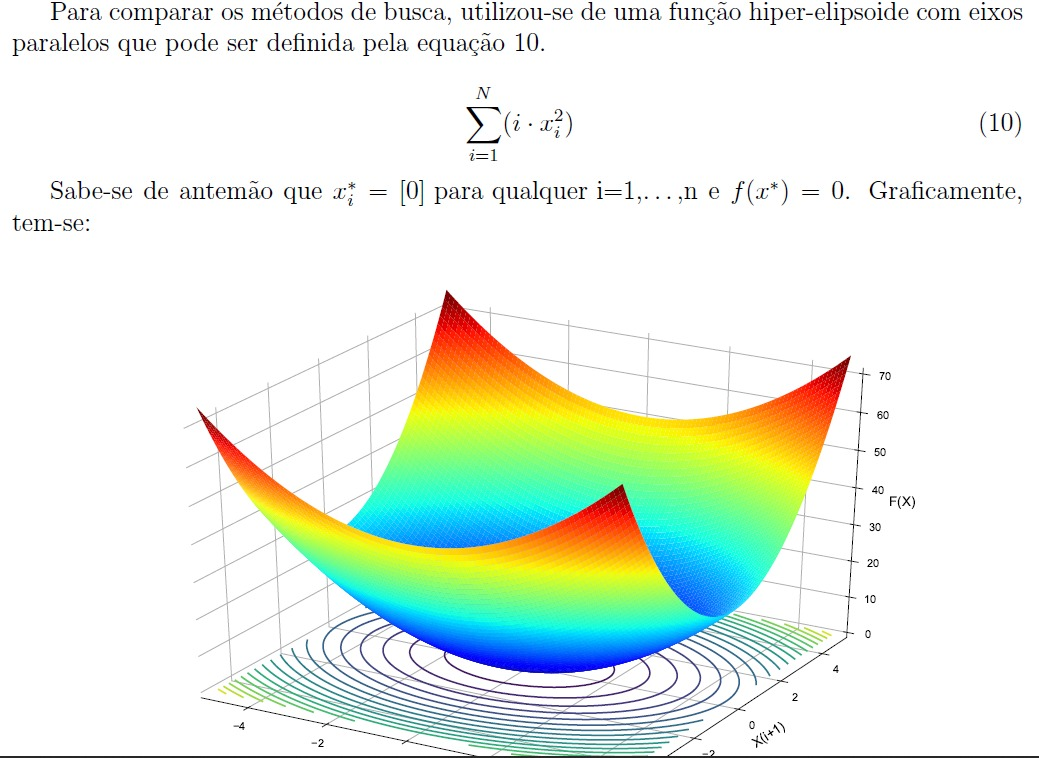

In [2]:
# Função:
x1, x2, x3 = sy.symbols('x_1 x_2 x_3')
fx = x1**2 + 2 * x2**2 + 3 * x3**2
fx

x_1**2 + 2*x_2**2 + 3*x_3**2

In [3]:
# Função para interpolação quadrática para o α:
def interp(x1, x2, x3, d1, d2, d3):
    faa = -9e9 # Valor inicial para f(α) para garantir pelo menos duas iterações
    j = 0      # Contador
    
    # Definição de f(α) com base nos valores atuais de x e d:
    alpha = sy.symbols(r'\alpha')
    x1t = x1 + alpha * d1
    x2t = x2 + alpha * d2
    x3t = x3 + alpha * d3
    fa = x1t**2 + 2 * x2t**2 + 3 * x3t**2
    fa = sy.Lambda(alpha, fa)
    #sy.plot(fa(alpha))
    
    #### Passos 1 e 2 (localização do intervalo de incerteza e cálculo do αi):
    alphal = 0         # Limite inferior inicial de alpha
    alphau = 2 * delta # Limite superior
    alphai = delta     # Ponto intermediário
    
    # Início do processo iterativo:
    while True:
        j += 1
        
        #### Passo 3 (cálculo dos coeficientes a e do α_):
        # Avaliação de f(α) nos três pontos:
        fal = fa(alphal)
        fau = fa(alphau)
        fai = fa(alphai)
        
        # Interpolação por polinômio de segundo grau (fórmula mostrada no Arora):
        a2 = 1/(alphau - alphai) * ((fau - fal)/(alphau - alphal) - (fai - fal)/(alphai - alphal))
        a1 = (fai - fal)/(alphai - alphal) - a2 * (alphal + alphai)
        a0 = fal - a1 * alphal - a2 * alphal**2
        
        # Condição necessária para minimização do polinômio:
        alpha_ = -a1/(2 * a2)
        
        # Condição suficiente:
        #if a2 > 0:
        #    pass

        # Avaliação de f(α) em α_:
        fa_ = fa(alpha_)

        #### Passos 4 e 5 (ajuste dos limites do intervalo de incerteza):
        if alphai < alpha_:
            if fai < fa_:
                alphau = alpha_
            else:
                alphal = alphai
                alphai = alpha_
        else:
            if fai < fa_:
                alphal = alpha_
            else:
                alphau = alphai
                alphai = alpha_

        # Verificação:
        intervalo = alphau - alphal
        #print(j, intervalo)
        
        # Se o intervalo de incerteza for suficientemente pequeno:
        if abs(intervalo) < tol_alpha:
            alpha = float((alphau + alphal)/2) # Retorna o valor médio de α no intervalo
            break

    return alpha, j

**Procedimento de otimização:**

xx = np.linspace(-1, 1, 21)
yy = np.linspace(-1, 1, 21)
zz = np.linspace(-1, 1, 21)

for m in xx:
    for n in yy:
        for o in zz:
            xi = [m, n, o] # Ponto de partida
            try:
                #### Passo 1:
                tol = 1e-2        # Tolerância para a norma do gradiente
                tol_alpha = 1e-4  # Tolerância para o intervalo de incerteza do alpha (interpolação)
                delta = 0.5       # Parâmetro do algoritmo para otimização do alpha (interpolação)
                alpha = 5e-2      # Para teste do programa com passo fixo
                imax = 5e2        # Número máximo de iterações

                x = np.matrix(xi) # Matriz numpy com os valores iniciais de x
                H = np.eye(3)     # Estimativa inicial para H é a identidade
                norm = 1e9        # Norma alta para garantir pelo menos duas iterações do while
                i = 0             # Contador de iterações
                aval = 0          # Contador de avaliações de funções
                xh = [xi]         # Para registrar o histórico de x
                alphah = [delta]  # Para registrar o histórico de alpha

                # Início do processo iterativo:
                while True:
                    i += 1
                    #print(i)
                    if i > imax:
                        print(f'Ponto inicial {xi}:')
                        print('Número máximo de iterações excedido!')
                        print(f'Quantidade de avaliações de função: {aval}\n')
                        erro = 1
                        break

                    #### Passo 2 (cálculo da norma do gradiente):
                    gx1 = 2 * x[0, 0] # Derivada parcial em relação a x1
                    gx2 = 4 * x[0, 1] # Derivada parcial em relação a x2
                    gx3 = 6 * x[0, 2] # Derivada parcial em relação a x3
                    grad = np.matrix([gx1, gx2, gx3]).T
                    norm = np.linalg.norm(grad)
                    grad = grad/norm

                    #### Passo 3 (cálculo da direção de descida):
                    d = np.linalg.inv(H) * (-grad)

                    #### Passo 4 (cálculo do alpha por interpolação):
                    x1, x2, x3 = x[0, 0], x[0, 1], x[0, 2]
                    d1, d2, d3 = d[0, 0], d[1, 0], d[2, 0]
                    alpha, j = interp(x1, x2, x3, d1, d2, d3)
                    aval += 4 * j
                    alphah.append(alpha)

                    #### Passo 5 (atualização do vetor x):
                    x = x + alpha * d.T
                    xh.append([x[0, 0], x[0, 1], x[0, 2]])

                    #### Passo 6 (atualização da Hessiana):
                    gx1 = 2 * x[0, 0] # Derivada parcial em relação a x1
                    gx2 = 4 * x[0, 1] # Derivada parcial em relação a x2
                    gx3 = 6 * x[0, 2] # Derivada parcial em relação a x3
                    grad_next = np.matrix([gx1, gx2, gx3]).T # Gradiente de k+1
                    grad_next = grad_next/(np.linalg.norm(grad_next))
                    y = grad_next - grad
                    s = alpha * d.T

                    D = (y * y.T) / (y * s)
                    E = (grad * grad.T) / (grad * d.T)
                    H = H + D + E

                    # Verificação:
                    if norm < tol:
                        f = x[0, 0]**2 + 2 * x[0, 1]**2 + 3 * x[0, 2]**2
                        print(f'Ponto inicial {xi}:')
                        print(f'Ótimo encontrado com {i} iterações: x* = {xh[-1]}')
                        print(f'Quantidade de avaliações de função: {aval}')
                        print(f'Valor de f(x1, x2, x3) no ponto ótimo: {round(f, 6)}\n')
                        erro = 0
                        break
            except:
                print(f'Ponto inicial {xi}: ERRO\n')

In [12]:
#### Passo 1:
#[-1.0, -1.0, 0.10000000000000009] 25
#[-1.0, -1.0, 1.0] 36
#[-1.0, -0.09999999999999998, -0.6] 344
#[-0.9, 0.40000000000000013, 0.6000000000000001] 10
#[-0.8, -0.09999999999999998, 0.30000000000000004] 10
#[-0.7, -0.6, -1.0] 31
#[-0.7, 0.30000000000000004, 0.30000000000000004] 166
#[-0.7, 0.40000000000000013, 0.40000000000000013] 17
#[-0.6, -1.0, 0.7000000000000002] 11
#[-0.6, -0.8, 0.40000000000000013] 20
#[-0.6, -0.09999999999999998, -0.19999999999999996] 18
#[-0.6, 0.6000000000000001, 0.10000000000000009] 10
#[-0.5, -0.9, 0.7000000000000002] 6
#[-0.3999999999999999, -0.8, 1.0] 16
#[-0.3999999999999999, -0.29999999999999993, 0.40000000000000013] 12
#[-0.3999999999999999, 0.20000000000000018, 0.20000000000000018] 32
#[-0.3999999999999999, 0.40000000000000013, 0.6000000000000001] 320
#[-0.3999999999999999, 0.7000000000000002, 0.6000000000000001] 15
#[-0.3999999999999999, 0.7000000000000002, 0.7000000000000002] 8
#[-0.3999999999999999, 0.7000000000000002, 0.9000000000000001] 13
#[-0.29999999999999993, -0.09999999999999998, -0.09999999999999998] 89

#xi = [-0.3999999999999999, 0.40000000000000013, 0.6000000000000001]
xi = [-0.5, -0.9, 0.7000000000000002] # Ponto de partida
tol = 1e-2        # Tolerância para a norma do gradiente
tol_alpha = 1e-4  # Tolerância para o intervalo de incerteza do alpha (interpolação)
delta = 0.5       # Parâmetro do algoritmo para otimização do alpha (interpolação)
alpha = 5e-2      # Para teste do programa com passo fixo
imax = 1e3        # Número máximo de iterações

x = np.matrix(xi) # Matriz numpy com os valores iniciais de x
H = np.eye(3)     # Estimativa inicial para H é a identidade
norm = 1e9        # Norma alta para garantir pelo menos duas iterações do while
i = 0             # Contador de iterações
aval = 0          # Contador de avaliações de funções
xh = [xi]         # Para registrar o histórico de x
alphah = [delta]  # Para registrar o histórico de alpha

fh = [xi[0]**2 + 2 * xi[1]**2 + 3 * xi[2]**2] # Histórico de f(x)
normh = [norm]                                # Histórico da norma

# Início do processo iterativo:
while True:
    i += 1
    #print(i)
    if i > imax:
        print('Número máximo de iterações excedido!')
        print(f'Quantidade de avaliações de função: {aval}')
        erro = 1
        break
    
    #### Passo 2 (cálculo da norma do gradiente):
    gx1 = 2 * x[0, 0] # Derivada parcial em relação a x1
    gx2 = 4 * x[0, 1] # Derivada parcial em relação a x2
    gx3 = 6 * x[0, 2] # Derivada parcial em relação a x3
    grad = np.matrix([gx1, gx2, gx3]).T
    norm = np.linalg.norm(grad)
    normh.append(norm)
    grad = grad/norm
    
    #### Passo 3 (cálculo da direção de descida):
    d = np.linalg.inv(H) * (-grad)

    #### Passo 4 (cálculo do alpha por interpolação):
    x1, x2, x3 = x[0, 0], x[0, 1], x[0, 2]
    d1, d2, d3 = d[0, 0], d[1, 0], d[2, 0]
    alpha, j = interp(x1, x2, x3, d1, d2, d3)
    aval += 4 * j
    alphah.append(alpha)
    
    #### Passo 5 (atualização do vetor x):
    x = x + alpha * d.T
    xh.append([x[0, 0], x[0, 1], x[0, 2]])
    fh.append(x[0, 0]**2 + 2 * x[0, 1]**2 + 3 * x[0, 2]**2)

    #### Passo 6 (atualização da Hessiana):
    gx1 = 2 * x[0, 0] # Derivada parcial em relação a x1
    gx2 = 4 * x[0, 1] # Derivada parcial em relação a x2
    gx3 = 6 * x[0, 2] # Derivada parcial em relação a x3
    grad_next = np.matrix([gx1, gx2, gx3]).T # Gradiente de k+1
    grad_next = grad_next/(np.linalg.norm(grad_next))
    y = grad_next - grad
    s = alpha * d.T

    D = (y * y.T) / (y * s)
    E = (grad * grad.T) / (grad * d.T)
    H = H + D + E
    
    # Verificação:
    if norm < tol:
        xs = [round(x[0, 0], 4), round(x[0, 1], 4), round(x[0, 2], 4)]
        fx
        print(f'ε = {tol}')
        print(f'ρ = {tol_alpha}')
        print(f'xi = {xi}')
        print(f'Ótimo encontrado com {i} iterações: x* = {xs}')
        print(f'Quantidade de avaliações de função: {aval}')
        print(f'Valor de f(x1, x2, x3) no ponto ótimo: {round(fh[-1], 6)}')
        print(f'Valor da norma do gradiente: {round(norm, 6)}')
        erro = 0
        break

x_1**2 + 2*x_2**2 + 3*x_3**2

n = 3
ε = 0.01
ρ = 0.0001
xi = [-0.5, -0.9, 0.7000000000000002]
Ótimo encontrado com 6 iterações: x* = [-0.0007, -0.0015, -0.001]
Quantidade de avaliações de função: 140
Valor de f(x1, x2, x3) no ponto ótimo: 8e-06
Valor da norma do gradiente: 0.009729


In [10]:
xh

[[-0.5, -0.9, 0.7000000000000002],
 [-0.30209935866543736, -0.1875576911955743, -0.13118269360516333],
 [0.003760107688281833, -0.014067920866124267, 0.008890703675778322],
 [0.008188735159816482, 0.0005796220690547828, 0.0059787180137275305],
 [0.004190153016125385, -0.0016403090958426454, -0.00048622422353472236],
 [0.0007023455701166185, -0.0015186511528708134, -0.0012448300600338977],
 [-0.0006504366728033136, -0.0014953544139216038, -0.0009649889585754751]]

In [11]:
fh

[3.3400000000000007,
 0.21324649486381586,
 0.0006470850403700397,
 0.00017496251426649557,
 2.3647852145008727e-05,
 9.754697583186133e-06,
 7.688848582314832e-06]

In [13]:
normh

[1000000000.0,
 5.6213877290220795,
 1.243954443741541,
 0.07790161760744375,
 0.039502144360952694,
 0.011035862264114866,
 0.009729318887075665]